In [3]:

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time


class IsingDemon:
    def __init__(self, L):
        self.L = L
        self.N = L * L
        self.lattice = np.ones((L, L), dtype=np.int8)
        self.critTemp = 2. / np.log(1. + np.sqrt(2.))
        self.temperature = self.critTemp
        self.mcs = 0
        self.energy = 0
        self.energyAccumulator = 0
        self.energySquaredAccumulator = 0
        self.magnetization = 0
        self.magnetizationAccumulator = 0
        self.magnetizationSquaredAccumulator = 0
        self.acceptedMoves = 0
        self.w = np.zeros(9)

        self.magnetization = self.N
        self.energy = -2 * self.N
        self.resetData()

        self.w[8] = np.exp(-8. / self.critTemp)  # is doing a tayor series expensive
        self.w[4] = np.exp(-4. / self.critTemp)

    def resetData(self):
        self.mcs = 0
        self.systemEnergyAccumulator = 0
        self.demonEnergyAccumulator = 0
        self.mAccumulator = 0
        self.m2Accumulator = 0
        self.acceptedMoves = 0
        self.magnetization_data = []
        self.systemEnergy_data = []
        self.my_temp = []
        self.susceptibility_data = []
        self.move_prob = []
        self.m2_data=[]

    def randomLattice(self):
        self.lattice = np.where( np.random.random((self.L, self.L))<.5,-1,1)
        self.magnetization=np.sum(self.lattice)
        self.energy= -2. *self.magnetization


    def specificHeat(self):
        energySquaredAverage = self.energySquaredAccumulator / self.mcs
        energyAverage = self.energyAccumulator / self.mcs
        heatCapacity = energySquaredAverage - energyAverage * energyAverage
        heatCapacity = heatCapacity / (self.temperature * self.temperature)

        return heatCapacity / self.N

    def changeTemperature(self, newTemperature):
        self.temperature = newTemperature
        self.w[8] = np.exp(-8. / self.temperature)
        self.w[4] = np.exp(-4. / self.temperature)

    def susceptibility(self):
        magnetizationSquaredAverage = self.magnetizationSquaredAccumulator / self.mcs
        magnetizationAverage = self.magnetizationAccumulator / self.mcs
        return (magnetizationSquaredAverage - magnetizationAverage * magnetizationAverage) / (self.temperature * self.N)

    def deltaE(self, i, j):
        return 2 * self.lattice[i, j] * (self.lattice[(i + 1) % self.L, j] + self.lattice[(i - 1 + self.L) % self.L, j]
                                         + self.lattice[i, (j + 1) % self.L] + self.lattice[
                                             i, (j - 1 + self.L) % self.L])

    def doOneMCStep(self):
        for k in range(self.N):
            i = np.random.randint(self.L - 1)
            j = np.random.randint(self.L - 1)

            dE = self.deltaE(i, j)
            if (0 >= dE) or self.w[dE] > np.random.random():
                newSpin = self.lattice[i, j] = -self.lattice[i, j]
                self.acceptedMoves += 1
                self.energy += dE
                self.magnetization += 2 * newSpin

            # only do stats every N steps?
            self.energyAccumulator += self.energy
            self.energySquaredAccumulator += self.energy * self.energy
            self.magnetizationAccumulator += self.magnetization
            self.magnetizationSquaredAccumulator += self.magnetization * self.magnetization

        self.mcs += 1
        self.my_temp.append(self.specificHeat())
        self.m2_data.append(self.magnetizationSquaredAccumulator/(self.mcs * self.N))
        self.magnetization_data.append(self.magnetizationAccumulator/(self.mcs * self.N))
        self.move_prob.append(self.acceptedMoves / (self.mcs * self.N))
        self.susceptibility_data.append(self.susceptibility())
        self.systemEnergy_data.append(self.energyAccumulator/(self.mcs * self.N))




In [4]:
def show_plots(N,temp,mCs,random,plot=True):
    N = N
    ising_model = IsingDemon(N)
    ising_model.changeTemperature(temp)
    if plot:
        fig, ax = plt.subplots(2, 3,figsize=(20, 10))
        if random:
            ising_model.randomLattice()
            fig.suptitle("Random Starts  Temp = {}".format(temp), fontsize=16)
        else:
            fig.suptitle("All Upspins Temp = {}".format(temp), fontsize=16)
    for i in range(mCs):
        ising_model.doOneMCStep()


    x_data = np.arange(1, ising_model.mcs + 1)

    # Initialize the dashboard
    if plot:
        im = ax[0, 0].imshow(ising_model.lattice, cmap='Greys', vmin=-1,vmax=1)
        heat_line, = ax[0, 1].plot(x_data, ising_model.my_temp, lw=1)

        move_prob_line, = ax[0, 2].plot(x_data, ising_model.move_prob, lw=1)
        mag_line, = ax[1, 0].plot(x_data, ising_model.magnetization_data, lw=1)
        susceptibility_line, = ax[1, 1].plot(x_data, ising_model.susceptibility_data, lw=1)

        energy_temp_line, = ax[1, 2].plot(x_data, ising_model.systemEnergy_data,'r', lw=1)
        ax[0, 0].set_title('System')
        ax[0, 1].set_title('Specific Heat')
        ax[0, 2].set_title('Move Probability')

        ax[1, 0].set_title('Magnetization')
        ax[1, 1].set_title('Susceptibility')
        ax[1, 2].set_title('Energy')
        plt.show()

    return [ising_model.my_temp,ising_model.move_prob, ising_model.magnetization_data, ising_model.systemEnergy_data, ising_model.m2_data]


## Problem 15.12

- (b) Visually determine if the spin configurations are “ordered” or “disordered” at T = 2 after equilibrium has been established.
    - The spin configuration seems to be ordered as the up and down spinds are mostly grouped togethere 
    
    
- (c) Repeat part (a) with the initial direction of each spin chosen at random. Make sure you explicitly compute the initial energy and magnetization in initialize. Does the equilibration time increase or decrease?
    - The time for equalibrium seems to increase  with random spins 
    
- (d) Repeat parts (a)–(c) for T = 2.5. 
    - The spin configuration seems to be still ordered but the grouping of down spins seems to be larger is size
    - The time for equalibrum seems to take loner and has larger fluxuations in Specific heat and energy 

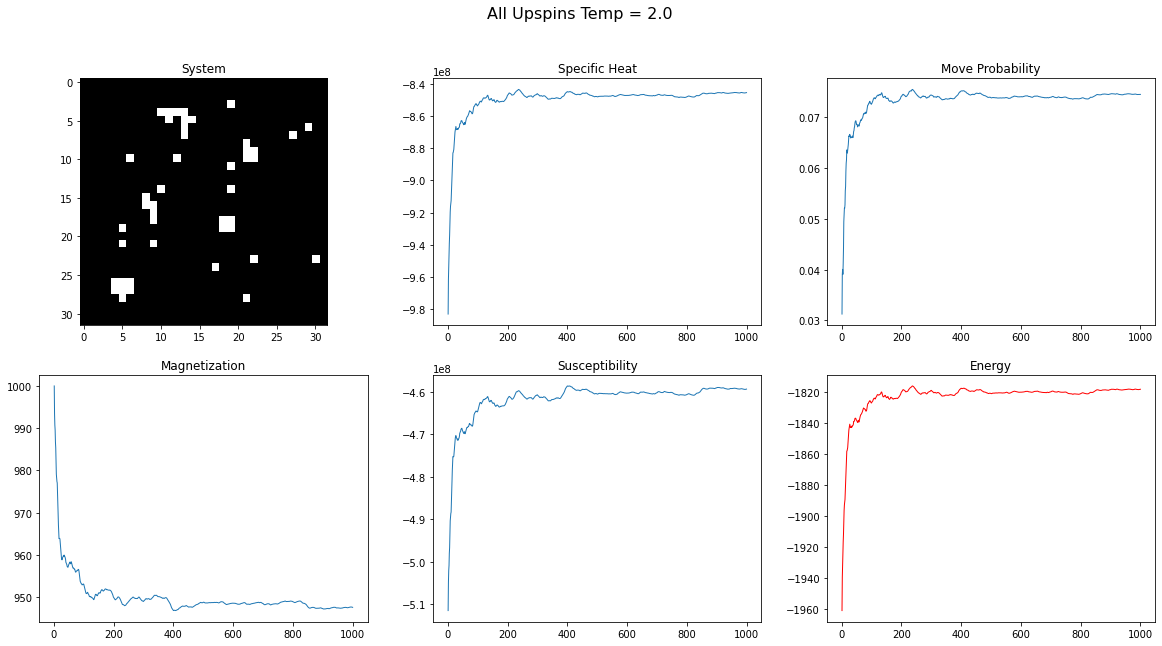

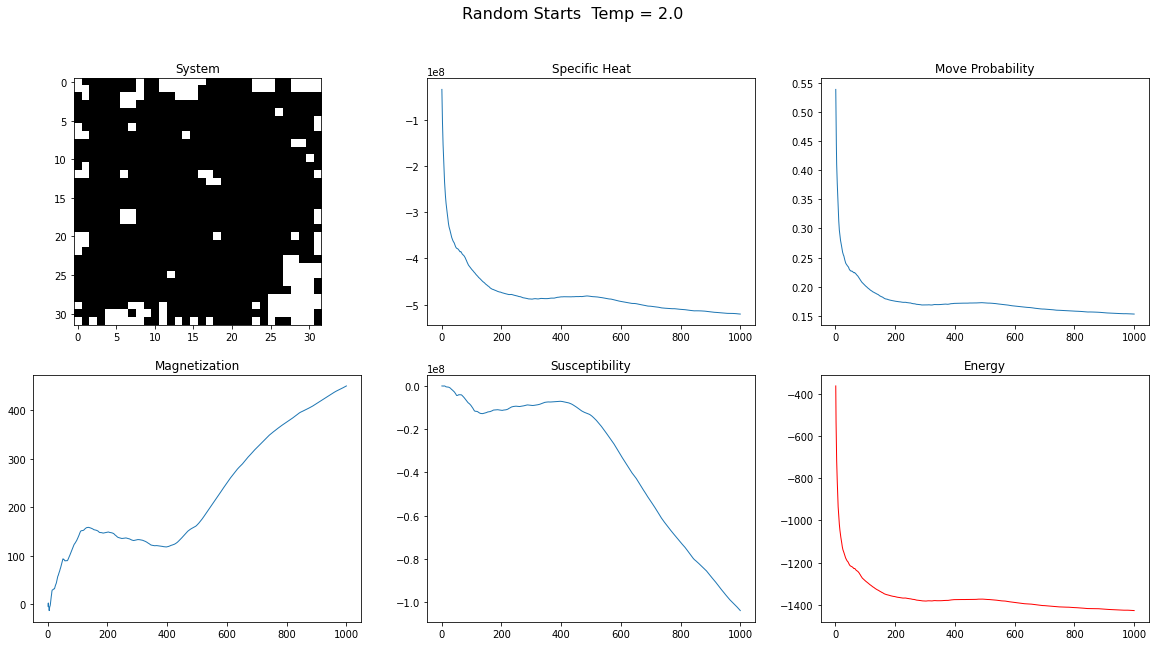

In [5]:
_=show_plots(32,2.0,1000,False)
_=show_plots(32,2.0,1000,True)

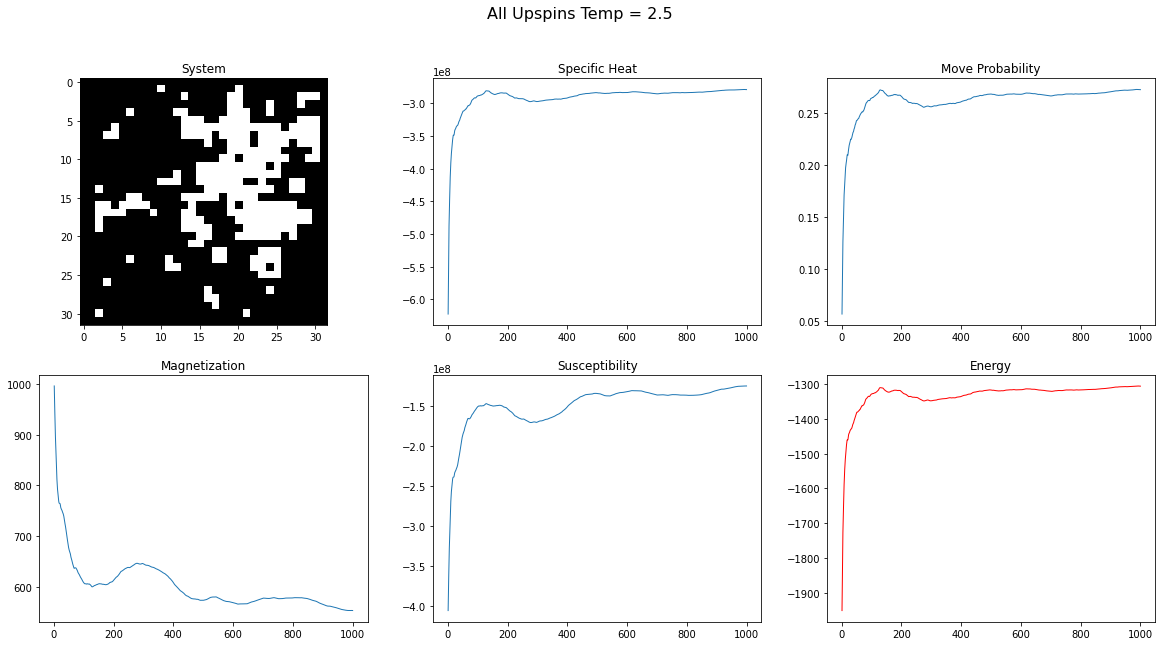

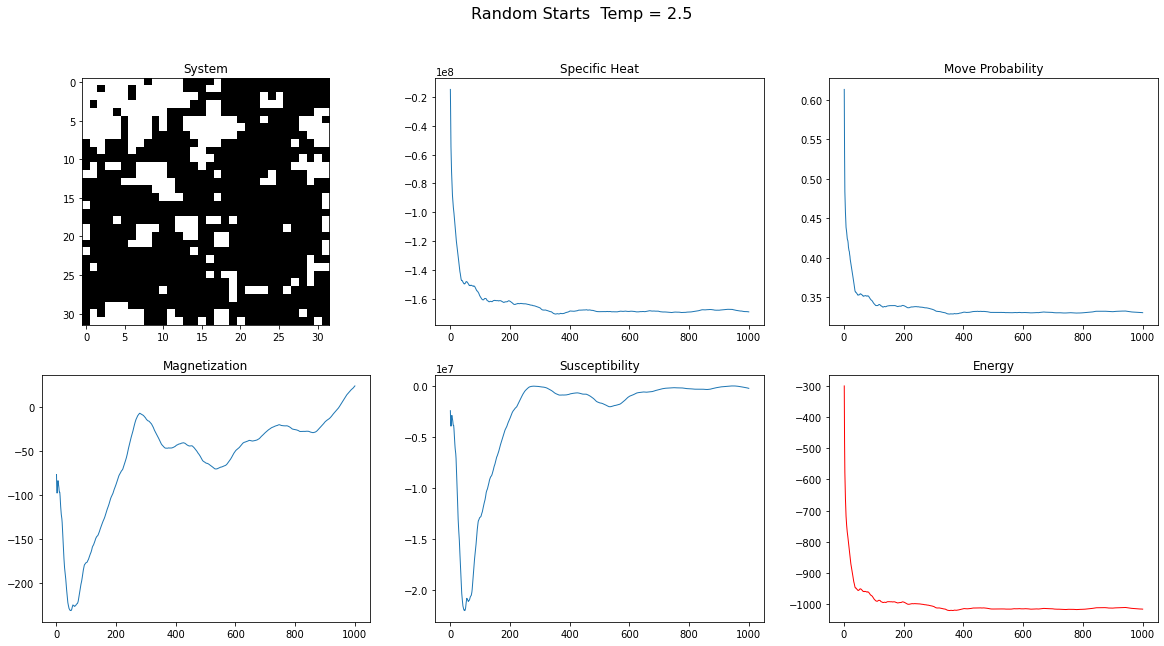

In [6]:
_ = show_plots(32,2.5,1000,False)
_ = show_plots(32,2.5,1000,True)

In [7]:
def find_accuaracy(my_range,L):
    my_up = {}
    my_rand = {}
    titles = ['Specific Heat','Move Probability','Magnetization','Susceptibility','Energy','M2']
    x_data = range(1000)
    for i in range(15,37,2):
        my_up[i]= show_plots(4,i/10.,1000,False,False)
        my_rand[i]= show_plots(4,i/10.,1000,True,False)
    fig, ax = plt.subplots(3,2,figsize=(20, 10))
    fig.suptitle("T={} All Up".format(L))
    for k in my_up:
        my_data_up = my_up[k]
        accuracy=[0]*5

        for i in range(5):
            ax[i//2,i%2].set_title(titles[i])
            for j in range(my_range*3,len(my_data_up[i])-my_range):
                denom = np.mean(my_data_up[i][j-my_range:j+my_range])
                accuracy = (np.abs(np.std(my_data_up[i][j-20:j+20] ))/denom)
                # print(accuracy)
                if accuracy<.05:
                    # print("Temp",k/10.," accuracy for ",titles[i],"is",accuracy,"at",j)
                    ax[i//2,i%2].axhline(y=my_data_up[i][j],xmin=0,xmax=1)
                    break
            ax[i//2,i%2].plot(x_data, my_data_up[i], lw=1,label=k/10.)
            ax[i//2,i%2].legend()
    plt.show()

    fig, ax = plt.subplots(3,2,figsize=(20, 20))
    fig.suptitle("T={} Random Ups".format(L))
    for k in my_up:
        my_data_up = my_rand[k]

        for i in range(4):
            ax[i//2,i%2].set_title(titles[i])
            for j in range(my_range,len(my_data_up[i])-my_range):

                denom = np.mean(my_data_up[i][j-my_range:j+my_range])

                accuracy = (np.abs(np.std(my_data_up[i][j-20:j+20] ))/denom)
                # print(accuracy)
                if accuracy<.05:
                    # print("Temp",k/10.," accuracy for ",titles[i],"is",accuracy,"at",j)
                    ax[i//2,i%2].axhline(y=my_data_up[i][j],xmin=0,xmax=1)
                    break
            ax[i//2,i%2].plot(x_data, my_data_up[i], lw=1,label=k/10.)
            ax[i//2,i%2].legend()

        print("Mean value for M {}".format(np.mean(my_data_up[4])))
        print("Mean value for |M| {}".format(np.mean(my_data_up[-1])))
    plt.show()




## Problem 15.16
- (a) Use at least 1000 Monte Carlo steps per spin and estimate the number of equilibrium configurations needed to obtain hMi and hEi to 5% accuracy. Plot hEi, m, |m|, C, and χ as a function of T and describe their qualitative behavior. Do you see any evidence of a phase transition?

    You can see the phase change start to happen as the magnetism greatly decreases as the temperature approaches the temp

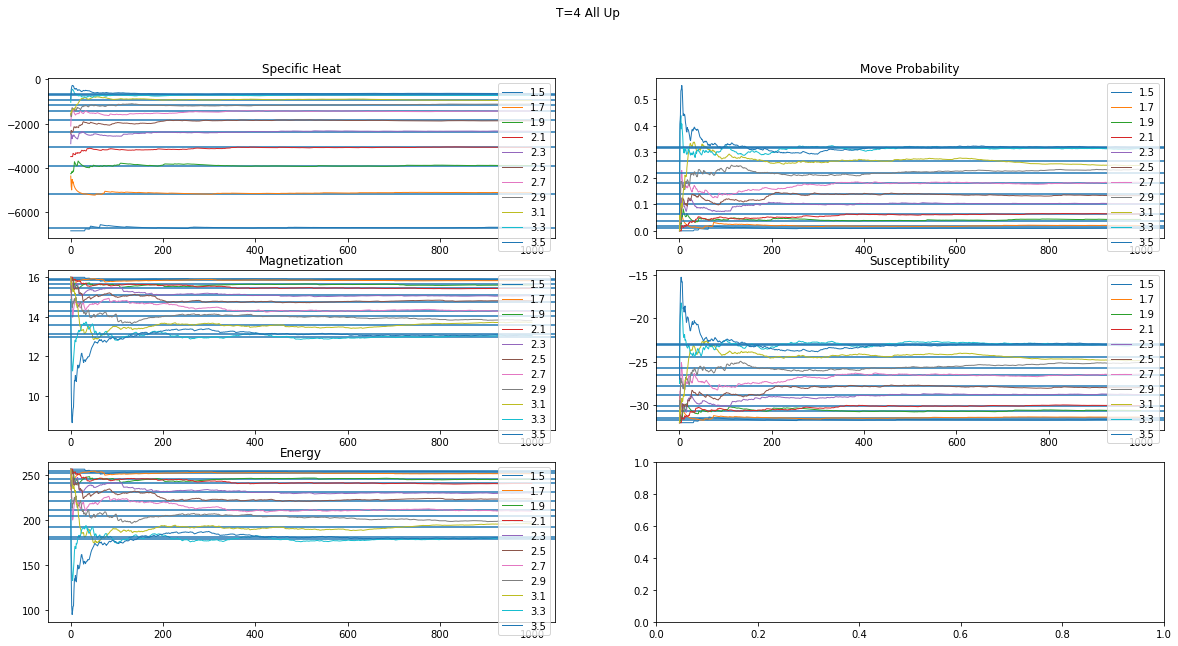

Mean value for M 251.90272230448906
Mean value for |M| 251.90272230448906
Mean value for M 250.09219183021074
Mean value for |M| 250.09219183021074
Mean value for M 243.63978253618146
Mean value for |M| 243.63978253618146
Mean value for M 239.0604724586064
Mean value for |M| 239.0604724586064
Mean value for M 228.7538419206214
Mean value for |M| 228.7538419206214
Mean value for M 224.7964096010034
Mean value for |M| 224.7964096010034
Mean value for M 215.77852843790623
Mean value for |M| 215.77852843790623
Mean value for M 200.6141696682744
Mean value for |M| 200.6141696682744
Mean value for M 192.90131200458094
Mean value for |M| 192.90131200458094
Mean value for M 189.71233172781655
Mean value for |M| 189.71233172781655
Mean value for M 170.87720826661806
Mean value for |M| 170.87720826661806


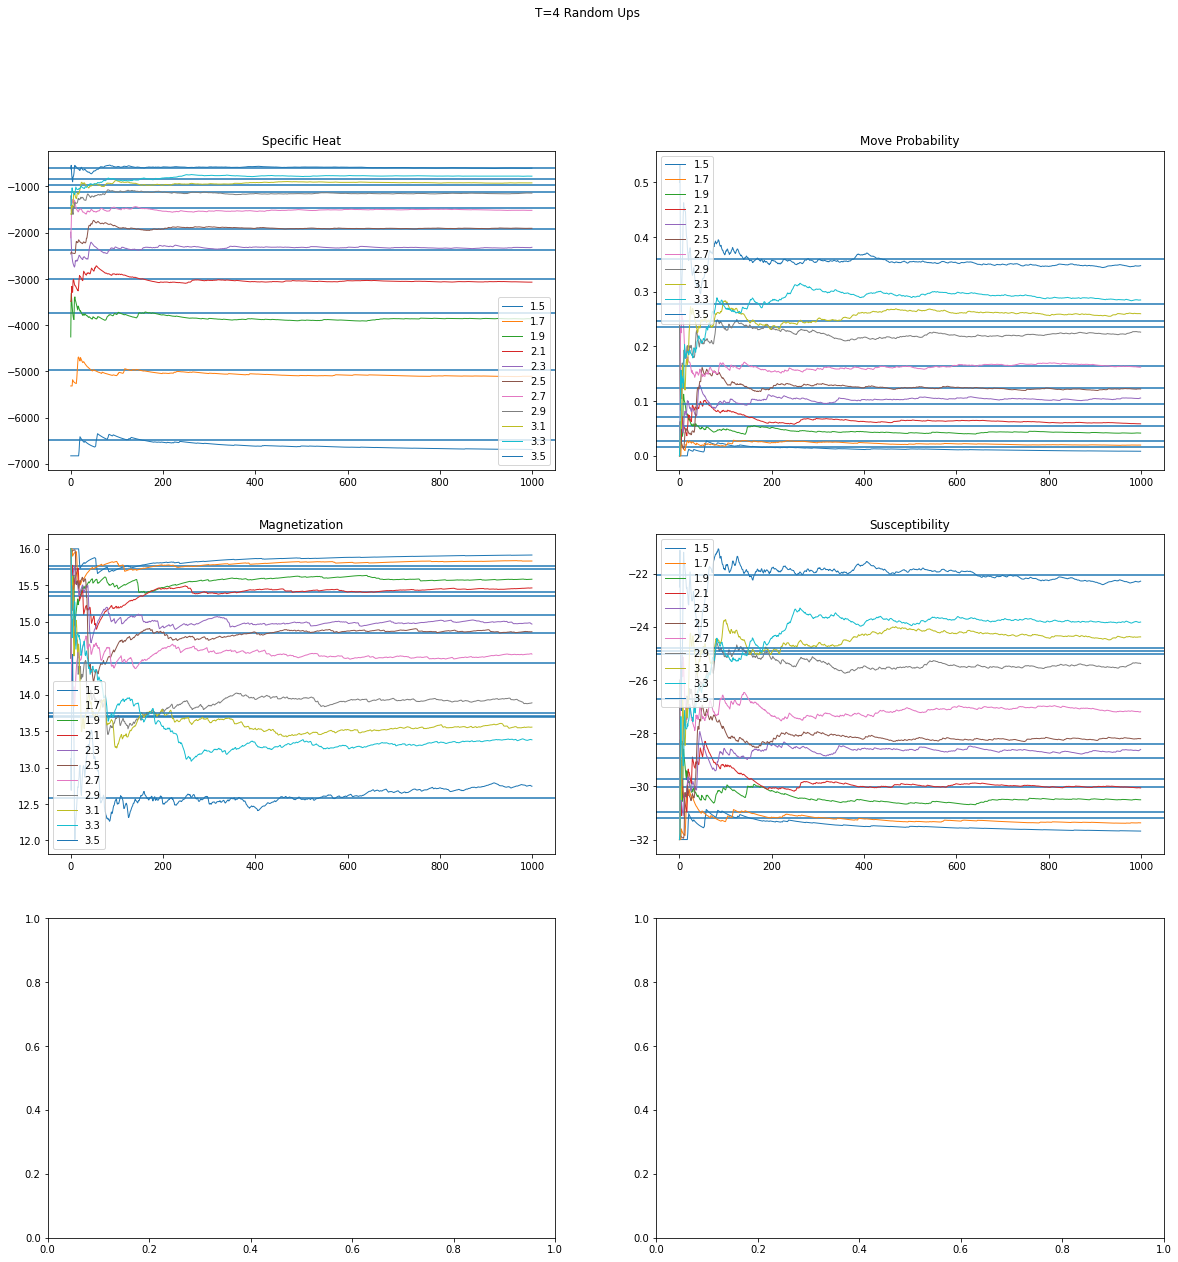

In [8]:
find_accuaracy(150,4)


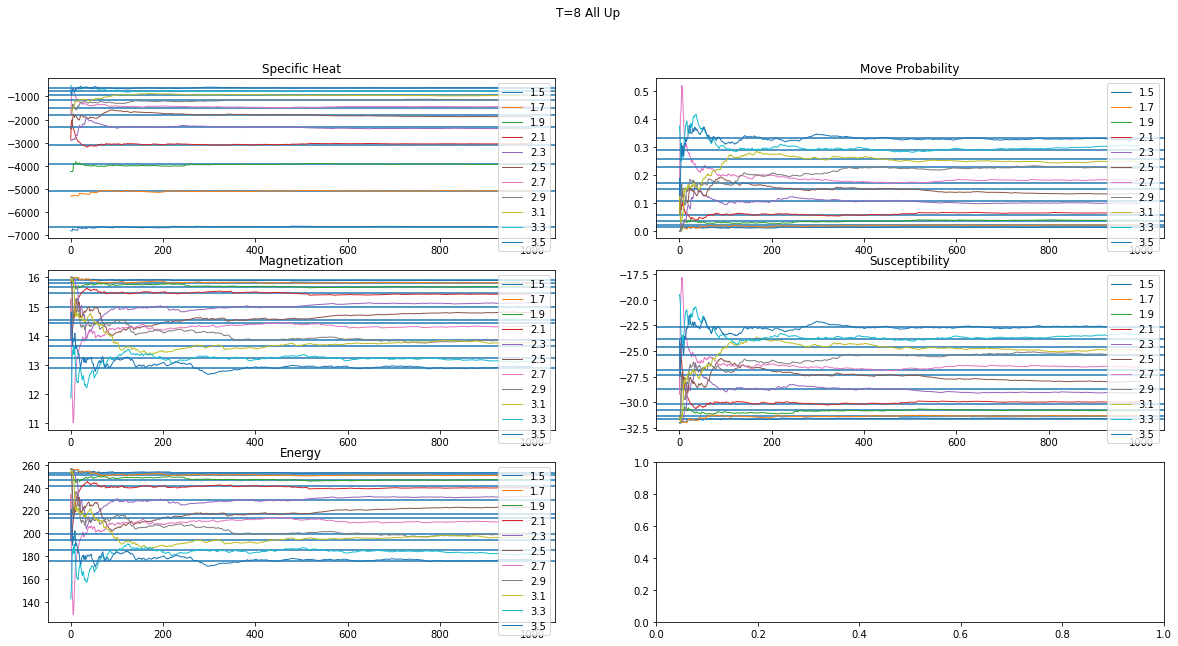

Mean value for M 252.8605676553817
Mean value for |M| 252.8605676553817
Mean value for M 251.5185141378432
Mean value for |M| 251.5185141378432
Mean value for M 246.80028985458887
Mean value for |M| 246.80028985458887
Mean value for M 242.82816121899836
Mean value for |M| 242.82816121899836
Mean value for M 231.30653675044132
Mean value for |M| 231.30653675044132
Mean value for M 224.82309921641817
Mean value for |M| 224.82309921641817
Mean value for M 216.41801310889394
Mean value for |M| 216.41801310889394
Mean value for M 194.24566526058422
Mean value for |M| 194.24566526058422
Mean value for M 190.73575955839976
Mean value for |M| 190.73575955839976
Mean value for M 181.26829719599715
Mean value for |M| 181.26829719599715
Mean value for M 174.5320596236976
Mean value for |M| 174.5320596236976


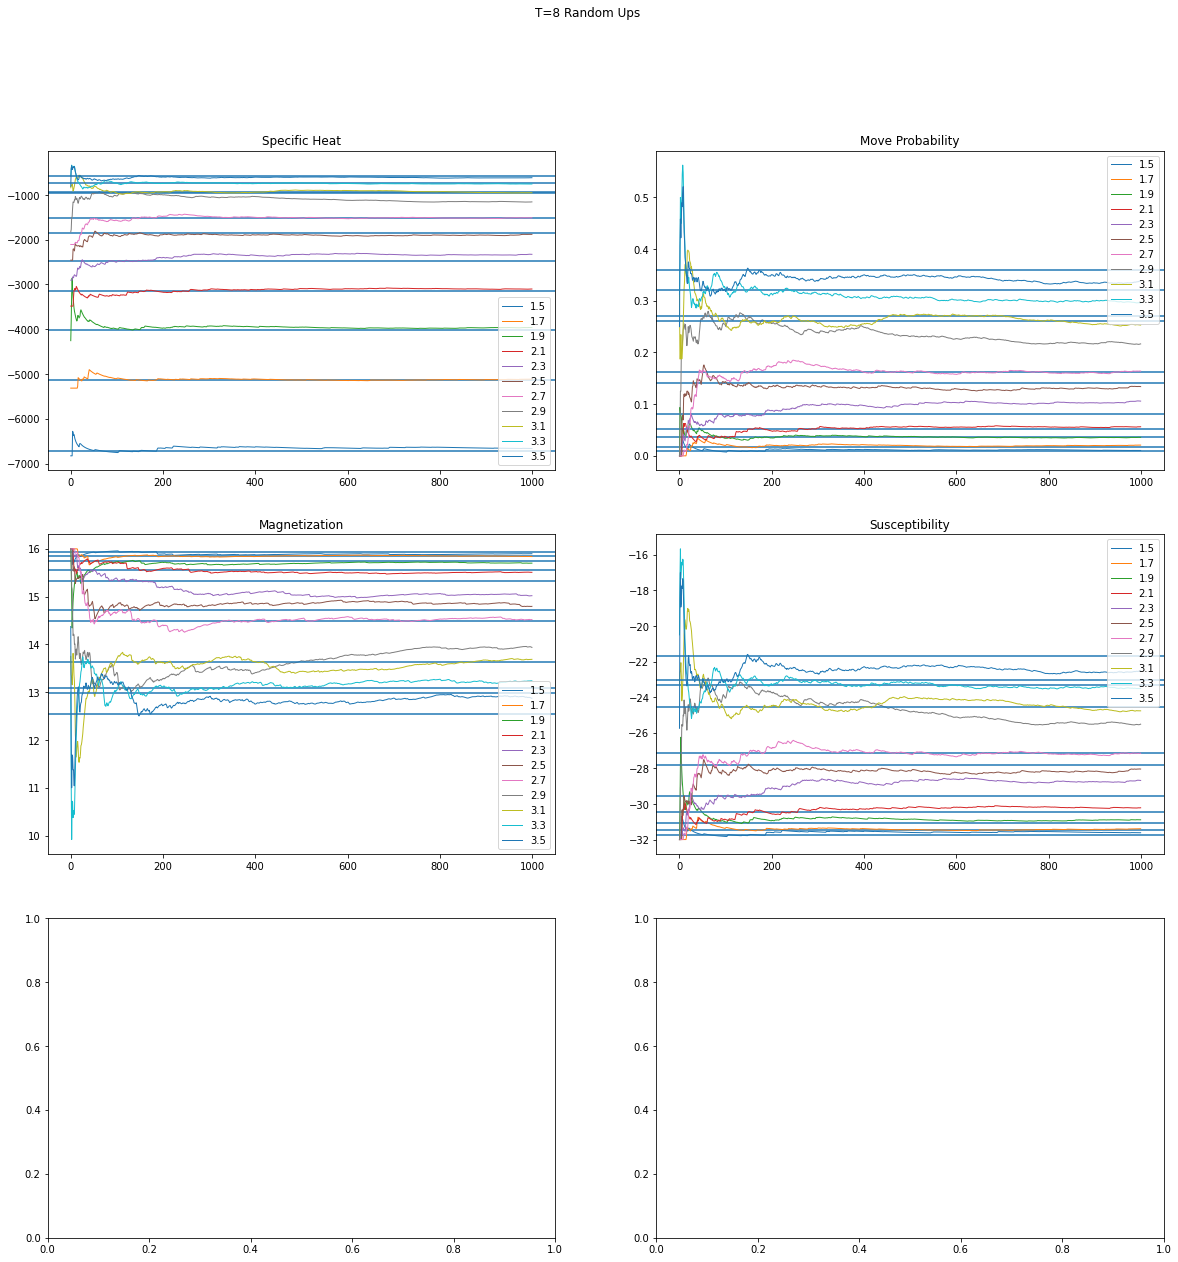

In [9]:
find_accuaracy(150,8)


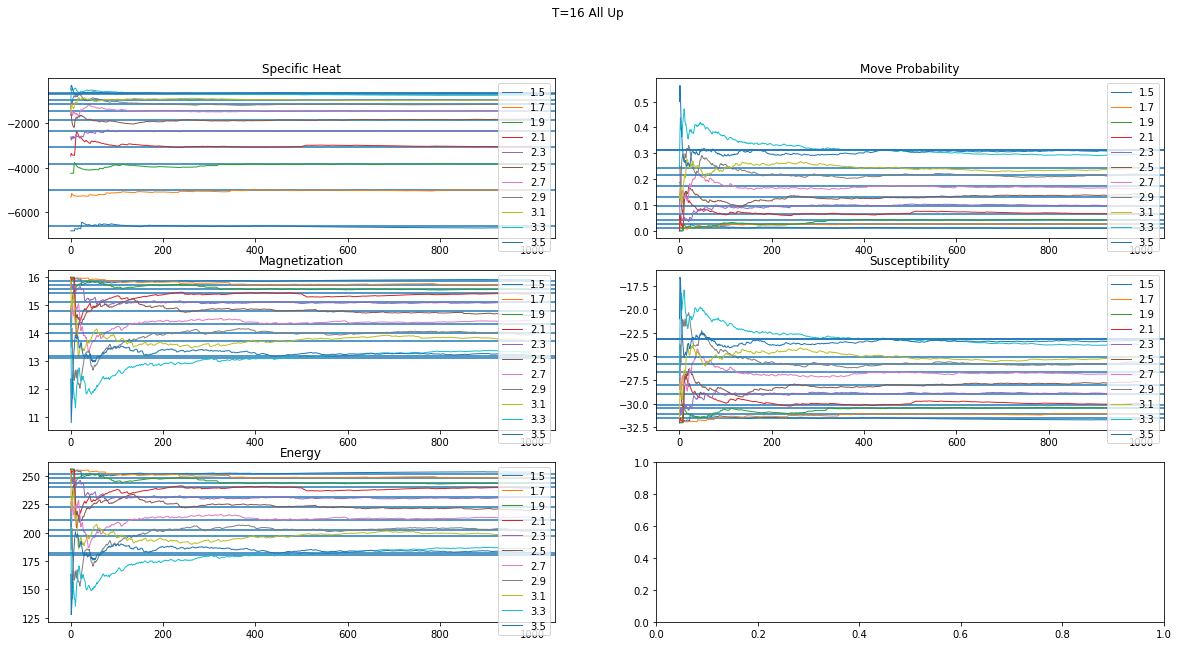

Mean value for M 253.079581404039
Mean value for |M| 253.079581404039
Mean value for M 249.96235062095965
Mean value for |M| 249.96235062095965
Mean value for M 244.21744396175515
Mean value for |M| 244.21744396175515
Mean value for M 237.36391555310342
Mean value for |M| 237.36391555310342
Mean value for M 228.53765604410367
Mean value for |M| 228.53765604410367
Mean value for M 221.2962670364597
Mean value for |M| 221.2962670364597
Mean value for M 213.61791028558994
Mean value for |M| 213.61791028558994
Mean value for M 207.1693897955858
Mean value for |M| 207.1693897955858
Mean value for M 190.0525891918019
Mean value for |M| 190.0525891918019
Mean value for M 188.05973453784983
Mean value for |M| 188.05973453784983
Mean value for M 182.51328868821136
Mean value for |M| 182.51328868821136


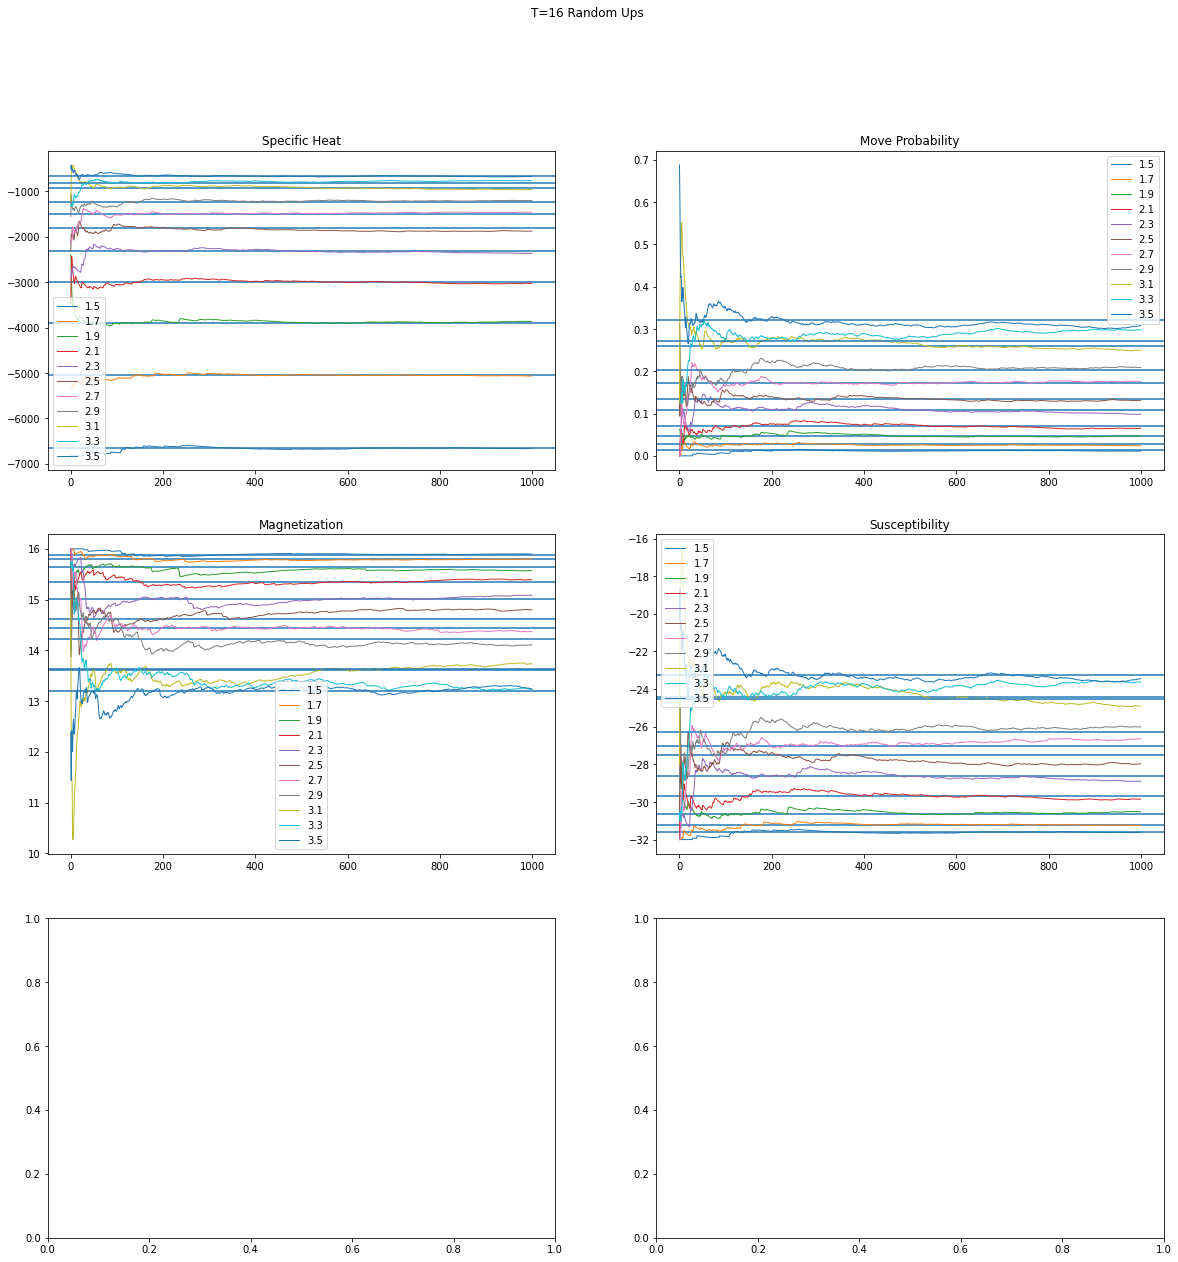

In [10]:
find_accuaracy(150,16)


 - (b) Is the evidence of a phase transition more obvious?
     - Yes it is more obvious. You can see the see that is reaches equilibrium faster and doesn't appear to overshoot its equilibrium state

